## Test using synthetic data
Steps:
- Generate N random permutations of size n (ground truth).
- Create relative permutation matrices 
- Add Gaussian noise to these 
- Apply your perm_sync to recover global consistent permutations.
- Measure accuracy against the original permutations.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.io import loadmat
from tqdm import tqdm
import sys, pathlib
import time


repo_root = pathlib.Path.cwd().parent        
sys.path.append(str(repo_root))

from permsync.perm_sync import perm_sync, error_against_ground_truth

In [2]:
def accuracy(pred, gt):
    graphs, _, kpts, _ = pred.shape
    correct = 0
    total = 0
    for i in range(graphs):
        pred_perm = pred[i, 0]
        gt_perm = torch.matmul(gt[i], gt[0].T)
        correct += torch.sum((pred_perm.argmax(1) == gt_perm.argmax(1)).int()).item()
        total += kpts
    return correct / total

In [10]:
def run_test(graphs=10, kpts=20, noise_std=0.3, seed=None, verbose=True):
    if seed is not None:
        torch.manual_seed(seed)
    
    start = time.time()
    # gt permutations
    perms_gt = []
    for _ in range(graphs):
        perm = np.eye(kpts)[np.random.permutation(kpts)]
        perms_gt.append(torch.tensor(perm, dtype=torch.float32))
        
    # relative permutations
    T = torch.zeros((graphs, graphs, kpts, kpts))
    for i in range(graphs):
        for j in range(graphs):
            T[i, j] = torch.matmul(perms_gt[i], perms_gt[j].T)
    
    # add gaussian noise
    T_noisy = T + noise_std * torch.randn_like(T)
    
    T_baseline = torch.zeros_like(T)
    for i in range(graphs):
        for j in range(graphs):
            cost_matrix = torch.max(T_noisy[i, j]) - T_noisy[i, j]  # Convert to cost
            row, col = linear_sum_assignment(cost_matrix.numpy())
            P_ij = torch.zeros_like(T_noisy[i, j])
            P_ij[row, col] = 1.0
            T_baseline[i, j] = P_ij
    
    T_synced = perm_sync(T_baseline, graphs, kpts)
    
    acc_baseline = accuracy(T_baseline, perms_gt)
    acc_synced = accuracy(T_synced, perms_gt)

    duration = time.time() - start

    if verbose:
        print(f"[graphs={graphs}, kpts={kpts}, noise={noise_std:.2f}] → "
              f"baseline: {acc_baseline:.4f}, synced: {acc_synced:.4f} "
              f"({duration:.2f}s)")
    
    return acc_baseline, acc_synced, duration

In [15]:
graph_vals = [6, 10, 14]
kpt_vals = [10, 20, 30]
noise_vals = [0.1, 0.3, 0.6, 0.9]

results = []

print("Running tests...\n")
for param_name, param_vals in [("graphs", graph_vals), ("kpts", kpt_vals), ("noise", noise_vals)]:
    baseline_acc = []
    synced_acc = []
    x_vals = []

    for val in tqdm(param_vals, desc=f"Testing {param_name}"):
        if param_name == "graphs":
            acc_b, acc_s, _ = run_test(graphs=val, kpts=20, noise_std=0.3, seed=42)
        elif param_name == "kpts":
            acc_b, acc_s, _ = run_test(graphs=10, kpts=val, noise_std=0.3, seed=42)
        elif param_name == "noise":
            acc_b, acc_s, _ = run_test(graphs=10, kpts=20, noise_std=val, seed=42)

        baseline_acc.append(acc_b)
        synced_acc.append(acc_s)
        x_vals.append(val)
        results.append((param_name, val, acc_b, acc_s))


Running tests...



Testing graphs: 100%|██████████| 3/3 [00:00<00:00, 25.71it/s]


[graphs=6, kpts=20, noise=0.30] → baseline: 1.0000, synced: 1.0000 (0.01s)
[graphs=10, kpts=20, noise=0.30] → baseline: 1.0000, synced: 1.0000 (0.03s)
[graphs=14, kpts=20, noise=0.30] → baseline: 1.0000, synced: 1.0000 (0.06s)


Testing kpts:   0%|          | 0/3 [00:00<?, ?it/s]

[graphs=10, kpts=10, noise=0.30] → baseline: 1.0000, synced: 1.0000 (0.02s)
[graphs=10, kpts=20, noise=0.30] → baseline: 0.9650, synced: 1.0000 (0.03s)


Testing kpts: 100%|██████████| 3/3 [00:00<00:00, 33.92it/s]


[graphs=10, kpts=30, noise=0.30] → baseline: 0.9900, synced: 1.0000 (0.03s)


Testing noise: 100%|██████████| 4/4 [00:00<00:00, 27.10it/s]

[graphs=10, kpts=20, noise=0.10] → baseline: 1.0000, synced: 1.0000 (0.03s)
[graphs=10, kpts=20, noise=0.30] → baseline: 1.0000, synced: 1.0000 (0.03s)
[graphs=10, kpts=20, noise=0.60] → baseline: 0.4650, synced: 0.6650 (0.04s)
[graphs=10, kpts=20, noise=0.90] → baseline: 0.2350, synced: 0.2000 (0.03s)


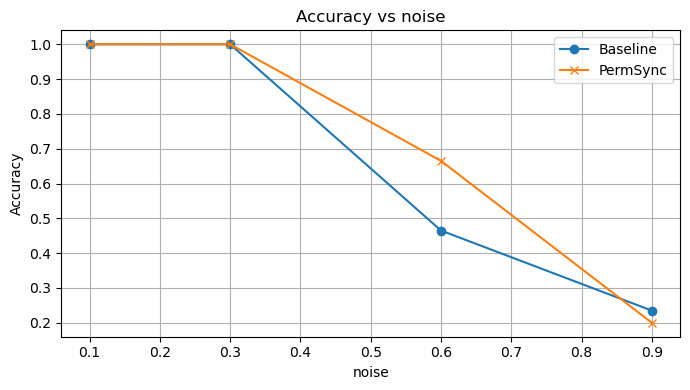

In [16]:
plt.figure(figsize=(7, 4))
plt.plot(x_vals, baseline_acc, marker='o', label="Baseline")
plt.plot(x_vals, synced_acc, marker='x', label="PermSync")
plt.title(f"Accuracy vs {param_name}")
plt.xlabel(param_name)
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()